# 2nd Level Model Structure: Reactive Stage

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.display_utility import trans_product_mole, trans_product_mass
from utility.model_utility import add_dual, update_dual, check_DOF

# stage construction rules
from physics.kinetics_bounded import kinetic_block_rule
from physics.energy_bounded import energy_block_rule
from physics.VLE_bounded import VLE_block_rule
from physics.MPCC_beta import beta_NCP_block_rule, beta_Reg_block_rule, beta_pf_block_rule

model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [3]:
model.inlet = pe.Set(initialize=['in'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet

# Global Variables

In [4]:
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)
model.H_F = pe.Var(within=pe.Reals)

# State Variable
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(200+273.15,300+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar

model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

model.cat = pe.Var(within=pe.NonNegativeReals,initialize=3000) # kg
model.Q_main = pe.Var(within=pe.Reals) # MW
model.r_total_comp = pe.Var(m.COMP_TOTAL,within=pe.Reals) # kmol/s

# Construct Individual Blocks

In [5]:
model.kinetics_block = pe.Block(rule=kinetic_block_rule)

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| kinetics_block.k_FT
| kinetics_block.r_FT_total
| kinetics_block.g0_FT
| kinetics_block.alpha
| kinetics_block.r_FT_cnum
| kinetics_block.r_FT_comp
| kinetics_block.k_WGS
| kinetics_block.Ke_WGS
| kinetics_block.r_WGS
| kinetics_block.r_WGS_comp
--------------------------------------------------



In [6]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [7]:
model.VLE_block = pe.Block(rule=VLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [8]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [9]:
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL,rule=VL_equil_rule)

## MPCC: Beta

In [10]:
model.MPCC = pe.Block(rule = beta_Reg_block_rule)

> Importing MPCC_beta_Reg Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC.beta
| MPCC.s_L
| MPCC.s_V
| MPCC.epi
--------------------------------------------------
> Adjusting the f_V = f_L bounds to f_V = beta * f_L



## Summation

\begin{equation}
\sum_ix_{i} = \sum_iy_{i} \\
F + L_{in} + V_{in} + R = L_{out} + V_{out}
\end{equation}

In [11]:
def summation_x_y_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == sum(model.y[i] for i in m.COMP_TOTAL)
model.summation_x_y_con = pe.Constraint(rule=summation_x_y_rule)

def summation_total_mass_rule(model):
    return model.F + sum(model.L[s] + model.V[s] for s in model.inlet) + sum(model.r_total_comp[i] for i in m.COMP_TOTAL)\
            - sum(model.L[s] + model.V[s] for s in model.outlet) == 0
model.summation_total_mass_con = pe.Constraint(rule=summation_total_mass_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [12]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Testing

In [13]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Fixing In/Product Redundent Flow

In [14]:
model.x_.fix(0)
model.y_.fix(0)
model.L['in'].fix(0)
model.L['P'].fix(0)
model.V['in'].fix(0)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(0)

## Fixing Model Parameters

In [15]:
model.cat.fix(3000)
model.P.fix(20)
model.T_F.fix(200+273.15)
model.F.fix(1)
model.z['CO'].fix(1/(1+0.8)-0/2)
model.z['H2'].fix(0.8/(1+0.8)-0/2)
model.z['C30H62'].fix(0)
model.VLE_block.n_ave.fix(20)

In [16]:
check_DOF(pe,model)

Active Equality Constraints:	 1182
Active Inequality Constraints:	 2
Active Variables:		 1357
Fixed Variables:		 172
DOF:				 3


## Fix T or to fix Q? we have found that Maximize against an upper bound is most reliable

In [17]:
model.T.setub(300+273.15)

In [18]:
# model.obj = pe.Objective(expr = model.L['out'],sense=pe.maximize)
# model.obj = pe.Objective(expr = model.cat,sense=pe.minimize)
model.obj = pe.Objective(expr = model.T ,sense=pe.maximize)

In [19]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
# opt.options['linear_solver'] = 'ma77'
# opt.options['ma57_automatic_scaling'] = 'no'
# opt.options['nlp_scaling_method'] = None
# opt.options['bound_relax_factor'] = 0
# opt.options['halt_on_ampl_error'] = 'yes'

opt.options['max_iter'] = 7000
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
max_iter=7000


List of user-set options:

                                    Name   Value                used
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4012
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:

  89 -5.3822723e+02 2.51e+00 1.23e+10  -3.8 3.34e+02    -  1.67e-01 4.44e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -5.3895717e+02 1.80e+00 7.61e+09  -3.8 3.37e+02    -  5.73e-03 3.80e-01h  1
  91 -5.3913866e+02 1.71e+00 7.17e+09  -3.8 5.52e+02    -  8.20e-01 5.75e-02h  1
  92 -5.4189685e+02 3.73e+00 4.48e+09  -3.8 6.03e+02    -  1.00e+00 8.01e-01f  1
  93 -5.4190706e+02 3.73e+00 4.48e+09  -3.8 1.26e+03    -  1.00e+00 1.44e-03h  1
  94r-5.4190706e+02 3.73e+00 1.00e+03   0.5 0.00e+00    -  0.00e+00 1.14e-07R  2
  95r-5.4191267e+02 3.02e+00 1.20e+03   0.5 8.92e+03    -  1.27e-03 1.91e-04f  1
  96 -5.4191533e+02 3.02e+00 2.18e+00  -3.8 1.24e+03    -  1.91e-04 3.83e-04h  1
  97 -5.4191813e+02 3.01e+00 2.80e+02  -3.8 3.71e+02    -  2.50e-03 1.34e-03f  1
  98 -5.4190689e+02 5.05e-01 3.09e+04  -3.8 2.99e+00    -  9.68e-04 8.32e-01h  1
  99 -5.4190687e+02 5.01e-01 3.00e+04  -3.8 9.83e-02   0.0 5.67e-01 6.75e-03f  2
iter    objective    inf_pr 

 186 -5.6991284e+02 2.14e-05 6.46e+05  -3.8 1.19e+01    -  2.53e-01 6.55e-02f  1
 187 -5.6991522e+02 1.85e-05 9.70e+05  -3.8 1.84e+00    -  8.42e-01 2.63e-01f  1
 188 -5.6992497e+02 4.63e-05 1.89e+07  -3.8 1.98e+00    -  1.00e+00 1.00e+00f  1
 189 -5.6992497e+02 4.62e-05 1.88e+07  -3.8 1.68e-06  12.9 4.59e-02 7.44e-04h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -5.6992242e+02 3.16e-06 2.25e+06  -3.8 5.18e-01    -  9.88e-01 1.00e+00h  1
 191 -5.6992242e+02 3.15e-06 2.12e+06  -3.8 5.14e-07  12.5 2.22e-01 4.86e-03h  3
 192 -5.6992232e+02 2.97e-06 1.92e+06  -3.8 3.60e-01    -  4.30e-02 5.80e-02h  1
 193 -5.6992105e+02 7.87e-07 1.56e+06  -3.8 2.58e-01    -  8.58e-01 1.00e+00f  1
 194r-5.6992105e+02 7.87e-07 1.00e+03  -3.8 0.00e+00    -  0.00e+00 4.22e-07R 18
 195r-5.6989715e+02 2.78e-04 8.55e+02  -3.8 3.36e+01    -  1.45e-01 1.45e-01f  1
 196r-5.6981273e+02 3.58e-03 1.77e+03  -3.8 2.89e+01    -  8.29e-01 5.94e-01f  1
 197r-5.6975571e+02 1.58e-03

In [20]:
model.T.value

573.15

In [21]:
model.MPCC.beta.value

0.12015575801905583

In [22]:
model.MPCC.s_L.value

0.8798453400917292

In [23]:
model.L['out'].value

5.382405778427885e-07

In [24]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}'.format(model.x[i].value,model.y[i].value))

Component		Liquid: 0.0000			Vapor: 0.4578
------------------------------------------------------------------------------------------------------------
H2         		 0.1371%			 0.3424%
CO         		 0.1236%			 0.2654%
CO2        		46.5966%			56.2353%
H2O        		10.9282%			 8.6187%
C2H4       		 5.6470%			 5.5917%
C3H6       		 5.8141%			 3.2153%
C4H8       		 2.3491%			 1.4282%
C5H10      		 1.6894%			 0.5529%
C6H12      		 1.3174%			 0.2585%
C7H14      		 0.9597%			 0.1208%
C8H16      		 0.6670%			 0.0565%
C9H18      		 0.4480%			 0.0264%
C10H20     		 0.2932%			 0.0123%
C11H22     		 0.1198%			 0.0037%
C12H24     		 0.0756%			 0.0017%
C13H26     		 0.0470%			 0.0008%
C14H28     		 0.0289%			 0.0004%
C15H30     		 0.0176%			 0.0002%
C16H32     		 0.0107%			 0.0001%
C17H34     		 0.0064%			 0.0000%
C18H36     		 0.0038%			 0.0000%
C19H38     		 0.0023%			 0.0000%
C20H40     		 0.0013%			 0.0000%
C1H4       		13.3744%			18.3934%
C2H6       		 3.2294%			 3.0063%
C3H8       		 1.3664%			

# Iterative Solve for Data Analysis

In [25]:
results_anchor = results
update_dual(pe,model)
model.solutions.store_to(results_anchor)

In [26]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [27]:
catrange = [3000,1000,500,300,100,50,10]
Trange = np.linspace(300+273.15,200+273.15,31)

In [28]:
rf_data_master = {}

for c in catrange:
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.cat ,sense=pe.minimize)

    model.solutions.load_from(results_anchor)
    update_dual(pe,model) 
       
    model.T.fix(300+273.15)
    model.cat.fixed = False
    model.cat.setlb(c)
    
    results_anchor = opt.solve(model,tee=False)
    model.solutions.store_to(results_anchor)
    update_dual(pe,model)
    
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.T,sense=pe.maximize)
    model.T.fixed = False
    model.cat.fixed = True
    
    
    print('\nWorking on Cat = {} kg'.format(model.cat.value))
    print('-'*108)
    
    rf_data = {}
    rf_data['x'] = {};rf_data['y'] = {};
    rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; rf_data['beta'] = []; 
    rf_data['s_L'] = [];
    for i in m.COMP_TOTAL:
        rf_data['x'][i] = []
        rf_data['y'][i] = []       

    for t in Trange:
        model.T.setub(t)
        results = opt.solve(model,tee=False)
        update_dual(pe,model)
        model.T.setub(300+273.15)
        print('Solved\t|T = {:.2f} K\t|V = {:.4f} kmol/s\t|L = {:.4f} kmol/s\t|s_L = {:.4f}\t|beta = {:.4f}'.\
              format(model.T.value,model.V['out'].value,model.L['out'].value,model.MPCC.s_L.value,model.MPCC.beta.value))
    
        rf_data['T'].append(model.T.value)
        rf_data['Q'].append(model.Q_main.value)
        rf_data['V'].append(model.V['out'].value)
        rf_data['L'].append(model.L['out'].value)
        rf_data['beta'].append(model.MPCC.beta.value)
        rf_data['s_L'].append(model.MPCC.s_L.value)

        for i in m.COMP_TOTAL:
            rf_data['x'][i].append(model.x[i].value)
            rf_data['y'][i].append(model.y[i].value)
        
    rf_data_master[c] = rf_data


Working on Cat = 3000.0 kg
------------------------------------------------------------------------------------------------------------
Solved	|T = 573.15 K	|V = 0.4578 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8798	|beta = 0.1202
Solved	|T = 569.82 K	|V = 0.4555 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8765	|beta = 0.1235
Solved	|T = 566.48 K	|V = 0.4530 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8727	|beta = 0.1273
Solved	|T = 563.15 K	|V = 0.4504 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8681	|beta = 0.1319
Solved	|T = 559.82 K	|V = 0.4477 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8626	|beta = 0.1374
Solved	|T = 556.48 K	|V = 0.4449 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8559	|beta = 0.1441
Solved	|T = 553.15 K	|V = 0.4420 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8477	|beta = 0.1523
Solved	|T = 549.82 K	|V = 0.4390 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8371	|beta = 0.1629
Solved	|T = 546.48 K	|V = 0.4360 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8234	|beta = 0.1766
Solved	|T = 543.15 K	|V = 0.4328 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.804

Solved	|T = 483.15 K	|V = 0.8503 kmol/s	|L = 0.0013 kmol/s	|s_L = 0.0004	|beta = 0.9996
Solved	|T = 479.82 K	|V = 0.8683 kmol/s	|L = 0.0012 kmol/s	|s_L = 0.0004	|beta = 0.9996
Solved	|T = 476.48 K	|V = 0.8847 kmol/s	|L = 0.0011 kmol/s	|s_L = 0.0004	|beta = 0.9996
Solved	|T = 473.15 K	|V = 0.8993 kmol/s	|L = 0.0010 kmol/s	|s_L = 0.0005	|beta = 0.9995

Working on Cat = 300.0 kg
------------------------------------------------------------------------------------------------------------
Solved	|T = 573.15 K	|V = 0.4811 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8865	|beta = 0.1135
Solved	|T = 569.82 K	|V = 0.4825 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8846	|beta = 0.1154
Solved	|T = 566.48 K	|V = 0.4845 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8826	|beta = 0.1174
Solved	|T = 563.15 K	|V = 0.4872 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8804	|beta = 0.1196
Solved	|T = 559.82 K	|V = 0.4909 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8779	|beta = 0.1221
Solved	|T = 556.48 K	|V = 0.4957 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8751

Solved	|T = 496.48 K	|V = 0.9742 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0315	|beta = 0.9685
Solved	|T = 493.15 K	|V = 0.9772 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0195	|beta = 0.9805
Solved	|T = 489.82 K	|V = 0.9800 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0141	|beta = 0.9859
Solved	|T = 486.48 K	|V = 0.9824 kmol/s	|L = 0.0001 kmol/s	|s_L = 0.0113	|beta = 0.9887
Solved	|T = 483.15 K	|V = 0.9846 kmol/s	|L = 0.0001 kmol/s	|s_L = 0.0098	|beta = 0.9902
Solved	|T = 479.82 K	|V = 0.9865 kmol/s	|L = 0.0001 kmol/s	|s_L = 0.0091	|beta = 0.9909
Solved	|T = 476.48 K	|V = 0.9882 kmol/s	|L = 0.0001 kmol/s	|s_L = 0.0089	|beta = 0.9911
Solved	|T = 473.15 K	|V = 0.9898 kmol/s	|L = 0.0001 kmol/s	|s_L = 0.0091	|beta = 0.9909

Working on Cat = 10.0 kg
------------------------------------------------------------------------------------------------------------
Solved	|T = 573.15 K	|V = 0.9363 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.9438	|beta = 0.0562
Solved	|T = 569.82 K	|V = 0.9421 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.9444	

# Optimization results across disappearing phases

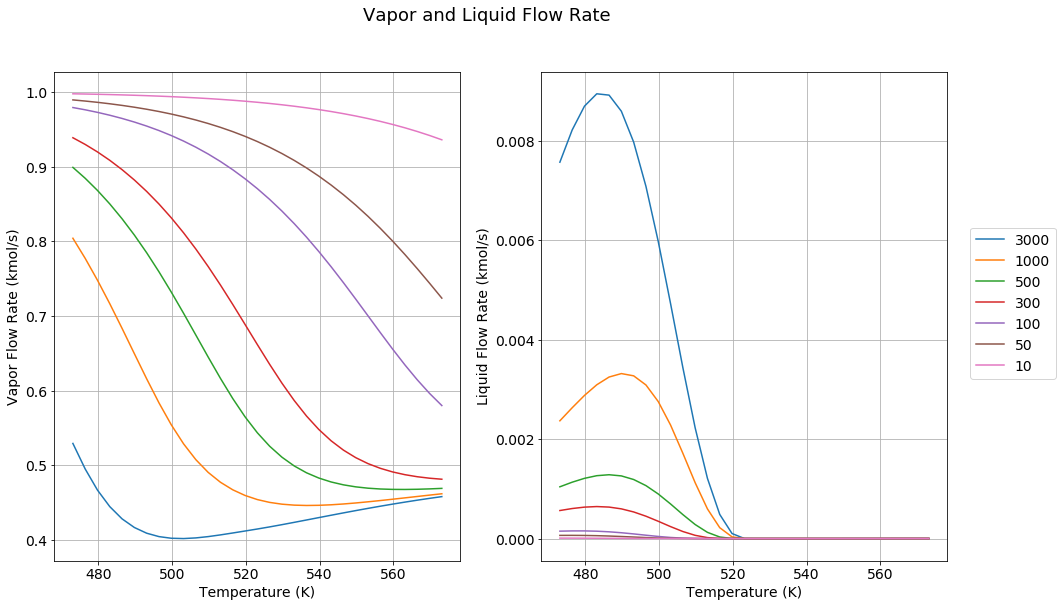

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,rf_data_master[c]['V'])
ax1.set_ylabel('Vapor Flow Rate (kmol/s)',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.grid()

for c in catrange:
    ax2.plot(Trange,rf_data_master[c]['L'])
ax2.set_ylabel('Liquid Flow Rate (kmol/s)',fontsize=14)
ax2.set_xlabel('Temperature (K)',fontsize=14)
ax2.tick_params(labelsize=14)
ax2.grid()

fig.legend(catrange,fontsize=14,loc=7)
fig.suptitle('Vapor and Liquid Flow Rate',fontsize=18)

plt.show()

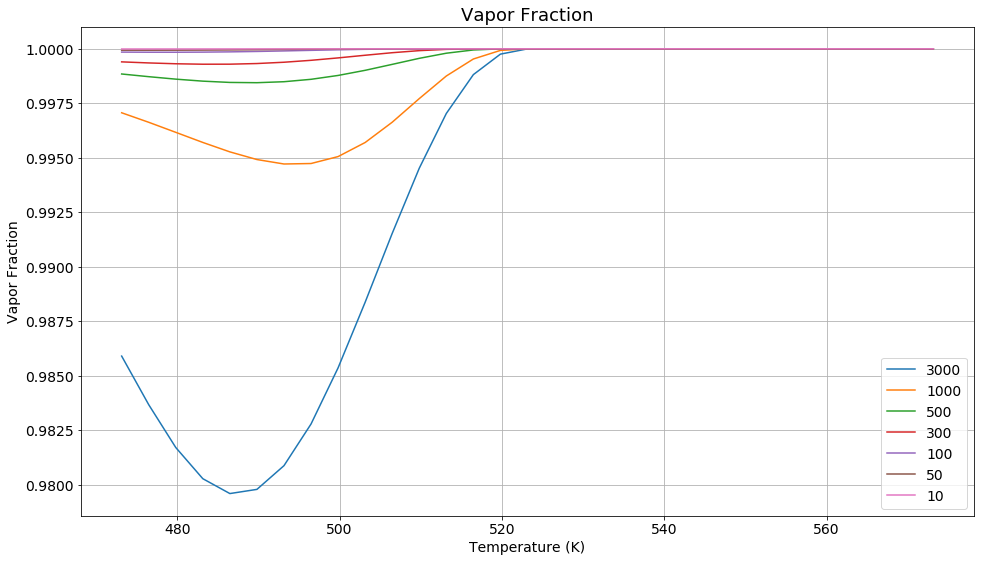

In [30]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,np.divide(rf_data_master[c]['V'],np.add(rf_data_master[c]['V'],rf_data_master[c]['L'])))
ax1.set_ylabel('Vapor Fraction',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
ax1.set_title('Vapor Fraction',fontsize=18)
ax1.grid()
plt.show()

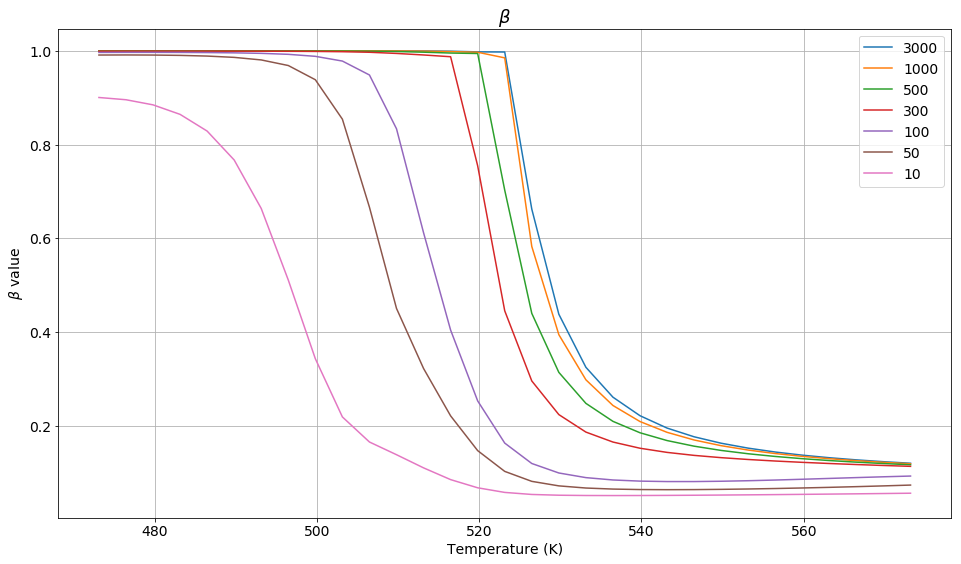

In [31]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,rf_data_master[c]['beta'])
ax1.set_ylabel(r'$\beta$ value',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
ax1.set_title(r'$\beta$',fontsize=18)
ax1.grid()
plt.show()

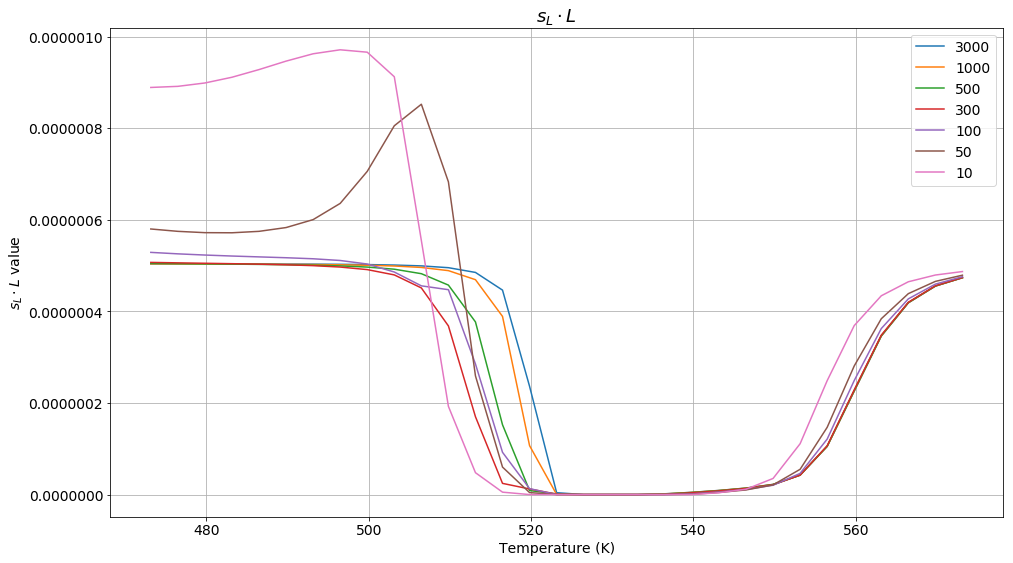

In [32]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,np.multiply(rf_data_master[c]['s_L'],rf_data_master[c]['L']))
ax1.set_ylabel(r'$s_L \cdot L$ value',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
# ax1.set_ylim(2.49e-5,2.51e-5)
ax1.set_title(r'$s_L \cdot L$',fontsize=18)
ax1.grid()
plt.show()